In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((224,224)) #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_data = torchvision.datasets.ImageFolder(root = 'Z:/Coding/ML-DL/DL_class/DATA/animal_dataset/train', transform=transform )
test_data = torchvision.datasets.ImageFolder(root = 'Z:/Coding/ML-DL/DL_class/DATA/animal_dataset/test', transform=transform )

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)


In [26]:
train_data.class_to_idx

{'butterfly': 0, 'cow': 1, 'elephant': 2, 'sheep': 3, 'squirrel': 4}

In [27]:
def find_key(dict, val):
  return next(key for key, value in dict.items() if value == val)

find_key(train_data.class_to_idx,4)

'squirrel'

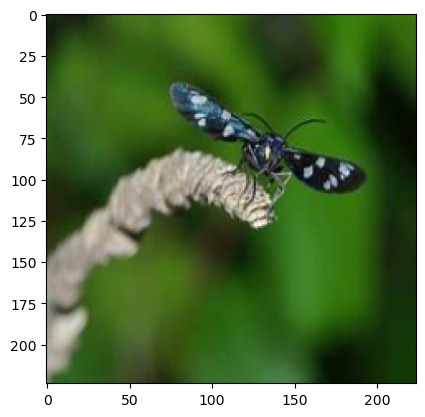

butterfly


In [72]:
train =  iter(train_loader)
images, label = train.next()
plt.show(plt.imshow(np.transpose(images[3],(1,2,0))))
print(find_key(train_data.class_to_idx,label[3]))

In [29]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else :
  device = torch.device('cpu')
print(device)

cuda


In [30]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [31]:
class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64*7*7, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #3x112x112
            nn.Conv2d(3,64,3, padding = 1),nn.ReLU(),
            nn.Conv2d(64,64,3, padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #64x56x56
            nn.Conv2d(64,128,3,padding = 1),nn.ReLU(),
            nn.Conv2d(128,128,3,padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #128x28x28
            nn.Conv2d(128,128,3,padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #256x14x14
        )
        self.fc1 = nn.Linear(128*14*14,4096)
        self.fc2 = nn.Linear(4096,1000)
        self.fc3 = nn.Linear(1000,5)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [33]:
net = Net().to('cuda')

# **Pretrained Model**

In [34]:
from torchvision import models

In [35]:
pretrained_vgg = models.vgg16(pretrained=True)

In [36]:
pretrained_resnet = models.resnet18(pretrained=True)

In [37]:
print(device)
num_classes = 5

cuda


In [38]:
pretrained_vgg.classifier[6] = nn.Linear(4096,num_classes)

pretrained_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
inplane = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(inplane, num_classes)
pretrained_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **모델요약**

In [40]:
from torchsummary import summary

summary(pretrained_resnet, input_size=(3, 224, 224), device=device.type)

C:\Users\gicht\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.001)

In [42]:
count = 0
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        pretrained_resnet.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pretrained_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

        if i % 100 == 99:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
          running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.645
[1,   200] loss: 1.536
[1,   300] loss: 1.596
[1,   400] loss: 1.360
[1,   500] loss: 1.328
[1,   600] loss: 1.264
[1,   700] loss: 1.292
[1,   800] loss: 1.323
[1,   900] loss: 1.208
[1,  1000] loss: 1.243
[1,  1100] loss: 1.071
[1,  1200] loss: 1.239
[1,  1300] loss: 1.103
[1,  1400] loss: 1.117
[1,  1500] loss: 1.078
[1,  1600] loss: 1.075
[1,  1700] loss: 1.130
[1,  1800] loss: 1.067
[1,  1900] loss: 1.043
[1,  2000] loss: 1.033
Finished Training


## **모델의 저장**

In [53]:
PATH = 'Z:\Coding\ML-DL\DL_class/DATA'

In [54]:
torch.save(pretrained_resnet.state_dict(), PATH + 'resnet_state_dict.pt')  # 모델 객체의 state_dict 저장

In [55]:
pretrained_resnet.load_state_dict(torch.load(PATH + 'resnet_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [56]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
      pretrained_resnet.eval()
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      # calculate outputs by running images through the network
      outputs = pretrained_resnet(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 76 %


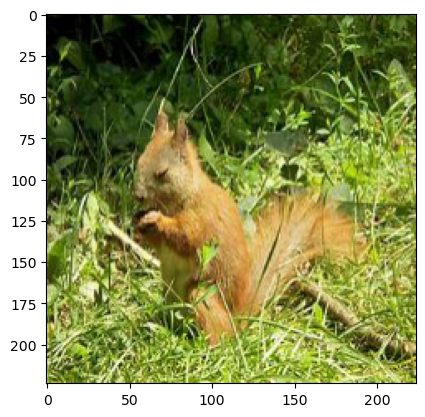

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
squirrel


In [73]:
with torch.no_grad():
  pretrained_resnet.eval()
  single_x = test_data[400][0]
  plt.show(plt.imshow(np.transpose(single_x,(1,2,0))))
  print(single_x.shape)
  single_x = single_x.unsqueeze(0)
  print(single_x.shape)
  #X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
  #Y_single_data = mnist_test.test_labels[r:r + 1].to(device)
  outputs = pretrained_resnet(single_x.to(device))

  print(find_key(test_data.class_to_idx,torch.argmax(outputs)))